<a href="https://colab.research.google.com/github/aleks-haksly/ClickHouse/blob/main/practice/part_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
import pandas as pd
import numpy as np
!pip install clickhouse_driver --quiet
from clickhouse_driver import Client
!pip install prophet --quiet
from prophet import Prophet
import holidays
from google.colab import userdata
import ipywidgets as widgets
import plotly.graph_objects as go
import seaborn as sns

In [2]:
# connection requisites
host = 'clickhouse.lab.karpov.courses'
dbase = 'default'
port = 9000
user = 'student'
password = userdata.get('ch2020[student]')

In [3]:
client = Client(host=host, port=port, user=user,
                password=password, database=dbase)

## [Prophet](https://github.com/facebook/prophet) for producing high quality forecasts for time series data that has multiple seasonality with linear or non-linear growth


### Задание 6.1
Задача прогнозирования временных рядов. Будем прогнозировать органические установки приложения по базе [Mobile installs](https://github.com/aleks-haksly/ClickHouse/tree/main/practice#mobile-installs)

In [4]:
sql = f"""
SELECT
  ds,
  uniqExact(DeviceID) as y
FROM installs
WHERE
  Source = 'Source_27' AND
  InstallCost = 0
GROUP BY toDateOrNull(InstallationDate) as ds
ORDER BY ds
"""
result, columns = client.execute(sql, with_column_types=True)
df = pd.DataFrame(result, columns=[tuple[0] for tuple in columns])

In [5]:
# починим колонку ds
df['ds'] = pd.to_datetime(df['ds'])
df.head()

,ds,y
0,2019-01-01,26243
1,2019-01-02,31303
2,2019-01-03,34017
3,2019-01-04,33807
4,2019-01-05,33925


In [6]:
holidays_dict = holidays.RUS([2015, 2016, 2017, 2018, 2019, 2020, 2021])

In [7]:
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index').reset_index()
df_holidays['index'] = pd.to_datetime(df_holidays['index'])
df_holidays = df_holidays.sort_values('index').rename(columns={'index': 'ds', 0: 'holiday'}).reset_index(drop=True)

In [52]:
n_predictions = 30
df_train = df[:-n_predictions]
df_test = df[-n_predictions:]

In [53]:
model = Prophet(holidays=df_holidays, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False)
model.fit(df_train);

DEBUG:cmdstanpy:input tempfile: /tmp/tmp64ay11mu/l2dgcq5p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp64ay11mu/nkudevq6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26729', 'data', 'file=/tmp/tmp64ay11mu/l2dgcq5p.json', 'init=/tmp/tmp64ay11mu/nkudevq6.json', 'output', 'file=/tmp/tmp64ay11mu/prophet_modelsj6oxwau/prophet_model-20240513093111.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:31:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:31:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [54]:
future = model.make_future_dataframe(periods=n_predictions)
forecast = model.predict(future)

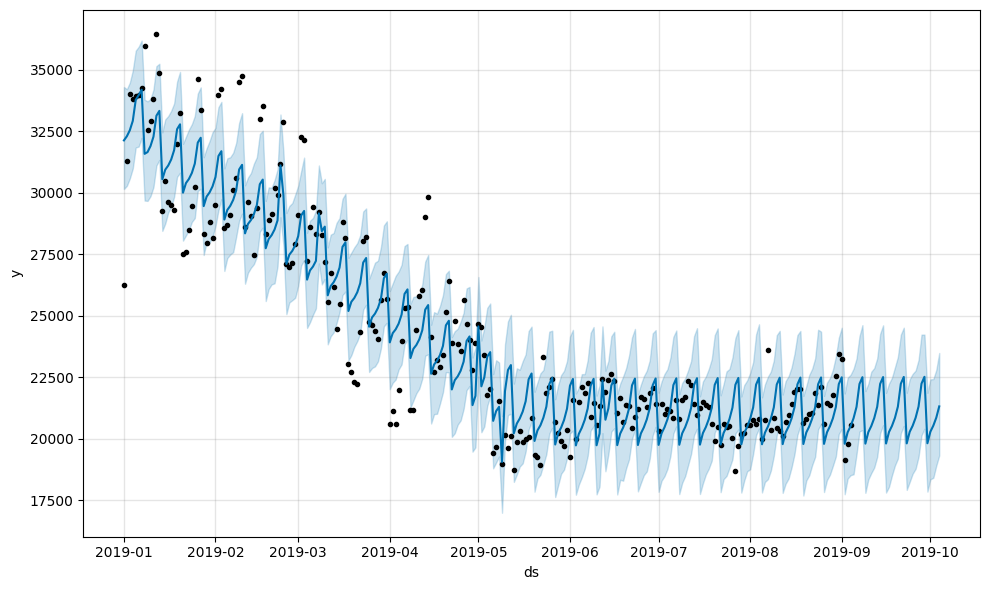

In [55]:
model.plot(forecast);

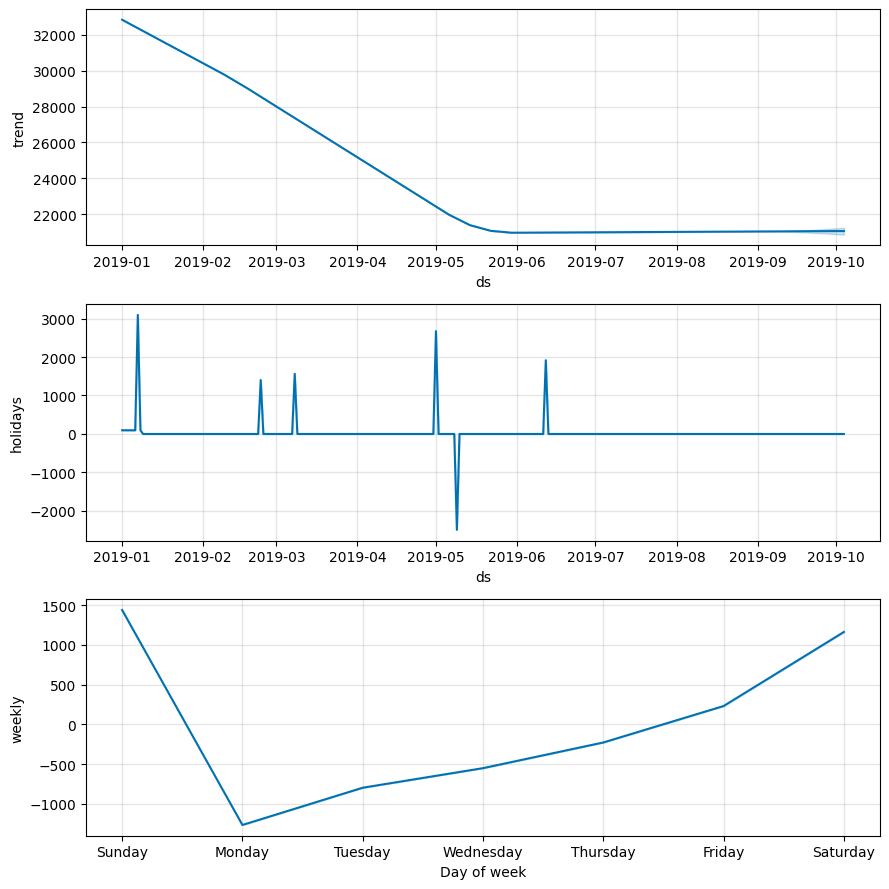

In [56]:
 model.plot_components(forecast);

In [57]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df['ds'], y=df['y'],
    name='fact',
    mode='lines',
))
fig.add_trace(go.Scatter(
    x=forecast['ds'], y=forecast['yhat'],
    name='prediction',
    mode='lines',
))
fig.add_trace(go.Scatter(
    x=forecast['ds'], y=forecast['yhat_upper'],
    name='upper',
    mode='none',
    fill='tonexty'
))
fig.add_trace(go.Scatter(
    x=forecast['ds'], y=forecast['yhat_lower'],
    name='lower',
    mode='none',
    fill='tonexty'
))
fig.add_trace(go.Scatter(
    x=forecast['ds'], y=forecast['trend'],
    name='trend'
))
fig.update_layout(title=f'Installations {n_predictions} days prediction')

In [58]:
# Посчитаем среднюю абюсолютную ошибку и среднюю аюсолютную ошибку в процентах
MAE = round(np.mean(abs(np.asarray(forecast['yhat']) - np.asarray(df['y']))[-n_predictions:]))
MAE_p = round(np.mean((abs(np.asarray(forecast['yhat']) - np.asarray(df['y'])) / abs(np.asarray(df['y']))*100)[-n_predictions:]), 2)
print(f'MAE: {MAE}')
print(f'MAE %: {MAE_p}')

MAE: 1080
MAE %: 5.56


DEBUG:cmdstanpy:input tempfile: /tmp/tmp64ay11mu/qg5x4ssw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp64ay11mu/_8v4kxou.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23028', 'data', 'file=/tmp/tmp64ay11mu/qg5x4ssw.json', 'init=/tmp/tmp64ay11mu/_8v4kxou.json', 'output', 'file=/tmp/tmp64ay11mu/prophet_modelxt5__bwy/prophet_model-20240513093113.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:31:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:31:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


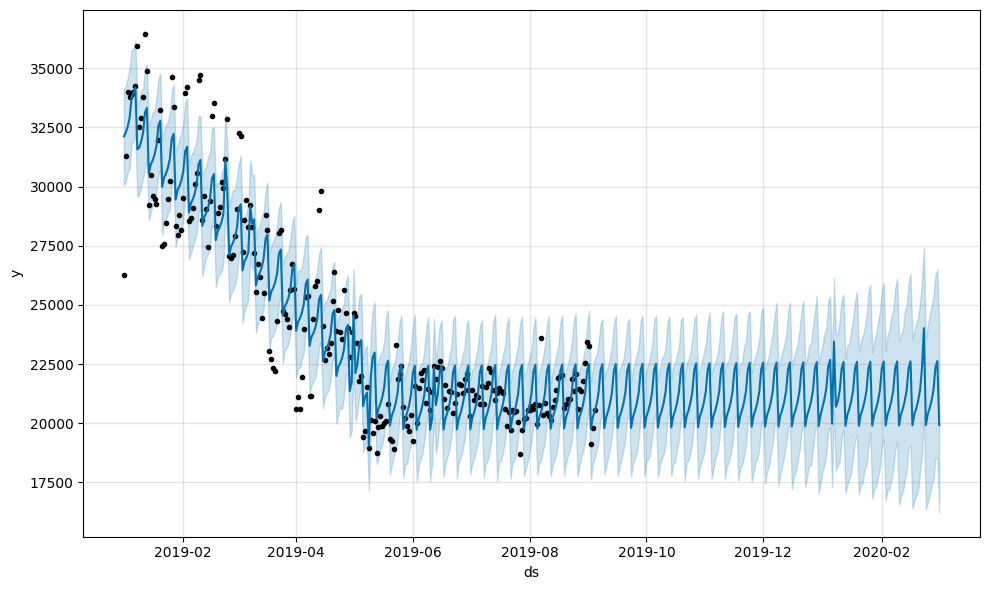

In [59]:
# Посмотрим на предсказание на 180 дней
n_predictions = 180
model = Prophet(holidays=df_holidays, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False)
model.fit(df_train)
future = model.make_future_dataframe(periods=n_predictions)
forecast = model.predict(future)
model.plot(forecast);

In [60]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df['ds'], y=df['y'],
    name='fact',
    mode='lines',
))
fig.add_trace(go.Scatter(
    x=forecast['ds'], y=forecast['yhat'],
    name='prediction',
    mode='lines',
))
fig.add_trace(go.Scatter(
    x=forecast['ds'], y=forecast['yhat_upper'],
    name='upper',
    mode='none',
    fill='tonexty'
))
fig.add_trace(go.Scatter(
    x=forecast['ds'], y=forecast['yhat_lower'],
    name='lower',
    mode='none',
    fill='tonexty'
))
fig.add_trace(go.Scatter(
    x=forecast['ds'], y=forecast['trend'],
    name='trend'
))
fig.update_layout(title=f'Installations {n_predictions} days prediction')

### Задание 6.2
На этот раз новый датасет **ldn_listings**, содержащий информацию об объявлениях на Airbnb в Лондоне. Выгрузите из таблицы данные о цене в зависимости от типа жилья и посчитайте 75-й перцентиль цены.

In [67]:
sql = f"""
SELECT
  room_type,
  quantile(0.75)(toFloat32OrNull(replaceRegexpAll(price, '[$,]', ''))) as percentile_75
FROM
  ldn_listings
GROUP BY room_type
"""
result, columns = client.execute(sql, with_column_types=True)
pd.DataFrame(result, columns=[tuple[0] for tuple in columns])

,room_type,percentile_75
0,Hotel room,213.75
1,Private room,60.00
2,Shared room,70.00
3,Entire home/apt,180.00


### Задание 6.3 ###
Давайте построим график рассеивания, который покажет зависимость средней оценки от средней цены по типу жилья.

In [69]:
sql = f"""
SELECT
  room_type,
  avg(toFloat32OrNull(replaceRegexpAll(price, '[$,]', ''))) as avg_price,
  avg(toFloat32OrNull(review_scores_rating)) as avg_rating
FROM
  ldn_listings
GROUP BY room_type
"""
result, columns = client.execute(sql, with_column_types=True)
df = pd.DataFrame(result, columns=[tuple[0] for tuple in columns])

<Axes: xlabel='avg_price', ylabel='avg_rating'>

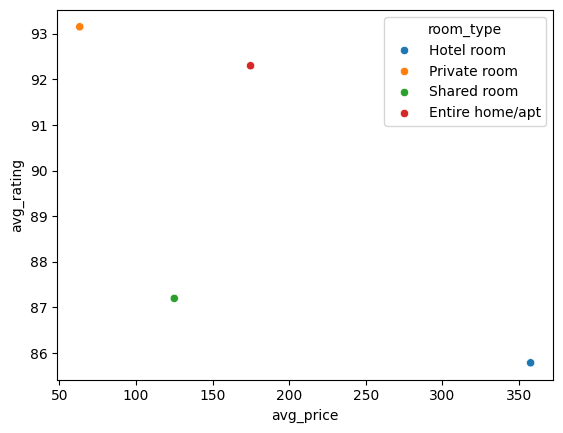

In [71]:
sns.scatterplot(df, x = 'avg_price', y='avg_rating', hue='room_type')

### Задание 6.4 ###
Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления <br>(experiences_offered != 'none')<br>
Посчитайте, сколько раз встречается каждый способ верификации.

In [76]:
sql = rf"""
SELECT
  arrayJoin(splitByString(' ', replaceRegexpAll(host_verifications, '[\[,\],\']', ''))) AS auth_type,
  count(*) as auth_cnt
FROM
  (SELECT DISTINCT host_id, host_verifications FROM ldn_listings WHERE experiences_offered != 'none') t
GROUP BY auth_type
ORDER BY auth_cnt DESC
"""
result, columns = client.execute(sql, with_column_types=True)
pd.DataFrame(result, columns=[tuple[0] for tuple in columns])

,auth_type,auth_cnt
0,phone,1361
1,email,1345
2,reviews,1309
3,government_id,1196
4,jumio,1115
5,offline_government_id,469
6,work_email,279
7,facebook,270
8,selfie,252
9,identity_manual,227
